# Classifying images with Caffe

We will classify some images with the pretrained GoogLeNet model that is available from [here](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet). GoogLeNet is an convolutional network architecture that won the Imagenet competition in 2014. For more details on the architecture, see [this paper](http://arxiv.org/abs/1409.4842).

![img](googlenet_diagram.png)

We assume that we're running from EC2 AMI, otherwise you need to download the googlenet model and set ```caffe_root``` and ```model_root``` variables below.

What we need for a pretrained model, is these files:
* deploy.prototxt - the model definition file
* bvlc_googlenet.caffemodel - a binary file with the learned model parameters


In [1]:
!cat ~/caffe/models/bvlc_googlenet/deploy.prototxt

name: "GoogleNet"
input: "data"
input_dim: 10
input_dim: 3
input_dim: 224
input_dim: 224
layer {
  name: "conv1/7x7_s2"
  type: "Convolution"
  bottom: "data"
  top: "conv1/7x7_s2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 64
    pad: 3
    kernel_size: 7
    stride: 2
    weight_filler {
      type: "xavier"
      std: 0.1
    }
    bias_filler {
      type: "constant"
      value: 0.2
    }
  }
}
layer {
  name: "conv1/relu_7x7"
  type: "ReLU"
  bottom: "conv1/7x7_s2"
  top: "conv1/7x7_s2"
}
layer {
  name: "pool1/3x3_s2"
  type: "Pooling"
  bottom: "conv1/7x7_s2"
  top: "pool1/3x3_s2"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "pool1/norm1"
  type: "LRN"
  bottom: "pool1/3x3_s2"
  top: "pool1/norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "conv2/3x3_reduce"
  type: "Convolution"
  bottom: "pool1/norm1"
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/home/ubuntu/caffe/' # this file is expected to be in {caffe_root}/examples
model_root = '/home/ubuntu/caffe/models/bvlc_googlenet/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [2]:
caffe.set_mode_gpu()
net = caffe.Net(model_root + 'deploy.prototxt', 
                model_root + 'bvlc_googlenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB (opencv)

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [5]:
# show image(s)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [3]:
%%time
im = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', im)
out = net.forward()
out['prob']
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #282.
CPU times: user 6.44 s, sys: 323 ms, total: 6.76 s
Wall time: 6.52 s


In [5]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02123159 tiger cat' 'n02123045 tabby, tabby cat'
 'n02124075 Egyptian cat' 'n02127052 lynx, catamount'
 'n02123394 Persian cat']


In [9]:
# CPU mode
caffe.set_mode_cpu()
net.forward() # call once for allocation

%timeit net.forward()

1 loops, best of 3: 7.14 s per loop


In [11]:
# GPU mode
#caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()  # call once for allocation

%timeit net.forward()

10 loops, best of 3: 90.9 ms per loop


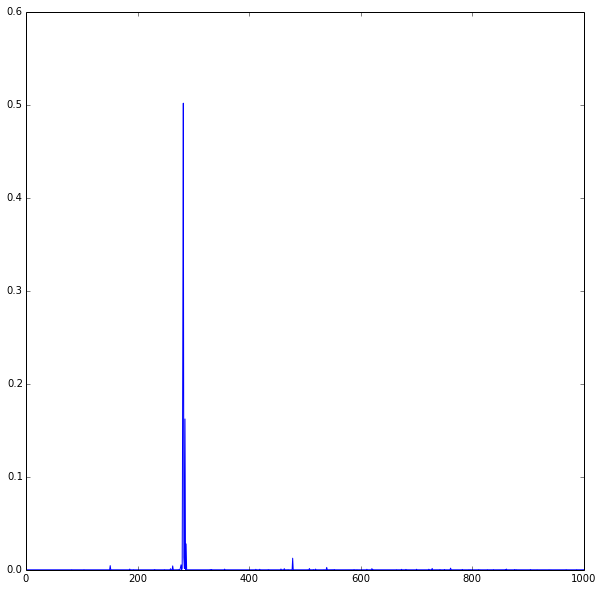

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)

In [ ]:
# test many images
# test many images
# test many images

## Features for image similarity

In [13]:
# insert an image
# do forward pass
# extract features from layers
net.blobs['pool5/7x7_s1'].data[0,:,0,0]
# can use with e.g. cosine distance for information retrieval

array([ 1.80815732,  0.15831138,  0.92137188, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [ ]:
# example from finn.no?